# 01 - WheresWally using R-CNN model

## Important note

You need to prepare the dataset before running this solution.

The cleaning of the dataset should be done before executing this script in order to achieve proper results.

The cleaning should be performed by using the script named `prepare_dataset.py` and the instructions on how to use are in the README in the root of this project. 

Installing required packages.

- Evaluation metrics uses the COCO metric for intersection over union.

In [1]:
%%shell
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-34e5pbvw
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-34e5pbvw
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263900 sha256=80b9defcf0dc222ec49a1870adb40a825706b6a09934625166697f7623ab42f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-rhfcqse4/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


## Defining the Dataset

I chose to use the torchivision interface from PyTorch to solve the object dectection task using a Mask-RCNN model.

For using this interface, it's necessary to create a Dataset class which implements some functions.

This class is defined on the next cells.

This script can be used inside google colab or directly in a local machine after cloning the main repository.

In this case, the whole repository will be cloned, but we will just use the data that is already cleaned up to train our model.

In [2]:
%%shell
rm -rf data
git clone https://github.com/gasparitiago/nuveo.git data

Cloning into 'data'...
remote: Enumerating objects: 400, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (279/279), done.
remote: Total 400 (delta 119), reused 397 (delta 119), pack-reused 0
Receiving objects: 100% (400/400), 82.85 MiB | 44.33 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [3]:
root_folder = 'data/'

In [4]:
# Defining the class

import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import json
import glob
import csv
import cv2

class WallyDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # sort the images and annotations
        self.imgs = list(sorted(glob.glob(root + '*.jpg')))
        self.json_files = list(sorted(glob.glob(root + '*.json')))

    def __getitem__(self, idx):
        # load images and json files
        img_path = self.imgs[idx]
        json_path = self.json_files[idx]

        # converting image to RGB
        img = Image.open(img_path).convert("RGB")

        # reading points and width and height from json files
        json_file = open(json_path)
        json_content = json.load(json_file)
        points = json_content['shapes'][0]['points']
        image_height = json_content['imageHeight']
        image_width = json_content['imageWidth']

        # Create the box independently of the order of points form json file
        xmin = np.min([points[0][0], points[1][0], points[2][0], points[3][0]]) 
        xmax = np.max([points[0][0], points[1][0], points[2][0], points[3][0]]) 
        ymin = np.min([points[0][1], points[1][1], points[2][1], points[3][1]]) 
        ymax = np.max([points[0][1], points[1][1], points[2][1], points[3][1]]) 

        boxes = []
        boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Create mask of background and foreground based on points
        mask = np.zeros([image_height, image_width], dtype=np.uint8)
        cv2.fillPoly(mask, pts=[np.array(points)], color=(1))
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]
        
        # Create the labels (just one class)
        labels = torch.ones((1,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Setting false as we don't have intersected objects in the same scene
        iscrowd = torch.zeros((1,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
# Verify how the dataset is structured
dataset = WallyDataset(root_folder + '01-WheresWally/TrainingSetClean/')
img, data = dataset[0]

## Defining the model based on TorchVision

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model (Resnet50) pre-trained on COCO dataset
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

## Training and evaluation functions

For evaluating the torchvision engine, I'm cloning the repository to get some useful functions and scripts.

In [7]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version



Create the transform function, responsible for data augmentation and tranforming the data to tensors. In this case, no data augmentation were used because the same reference images was used and the objection detection is very simple.


In [8]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform():
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

## Defining the training and validation subsets



In [9]:
# Create the training and validation datasets.
dataset = WallyDataset(root_folder + '01-WheresWally/TrainingSetClean/', get_transform())

# split the dataset in train and validation set (90 / 10)
size_split = len(dataset) - len(dataset) // 10
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset, indices[:size_split])
dataset_validation = torch.utils.data.Subset(dataset, indices[size_split:len(dataset)])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_validation = torch.utils.data.DataLoader(
    dataset_validation, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Defining optimizer

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# background and wally
num_classes = 2

model = get_instance_segmentation_model(num_classes)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


## Model training

In [11]:
# train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # # evaluate on the test dataset
    evaluate(model, data_loader_validation, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [ 0/51]  eta: 0:00:58  lr: 0.000105  loss: 3.7144 (3.7144)  loss_classifier: 0.3758 (0.3758)  loss_box_reg: 0.1644 (0.1644)  loss_mask: 3.1643 (3.1643)  loss_objectness: 0.0067 (0.0067)  loss_rpn_box_reg: 0.0032 (0.0032)  time: 1.1388  data: 0.3819  max mem: 1876
Epoch: [0]  [10/51]  eta: 0:00:23  lr: 0.001104  loss: 1.7573 (1.8444)  loss_classifier: 0.2190 (0.2314)  loss_box_reg: 0.1683 (0.1834)  loss_mask: 1.3708 (1.4211)  loss_objectness: 0.0063 (0.0062)  loss_rpn_box_reg: 0.0030 (0.0024)  time: 0.5652  data: 0.0447  max mem: 3020
Epoch: [0]  [20/51]  eta: 0:00:16  lr: 0.002103  loss: 0.4454 (1.1384)  loss_classifier: 0.0902 (0.1585)  loss_box_reg: 0.1642 (0.1715)  loss_mask: 0.2094 (0.8019)  loss_objectness: 0.0016 (0.0046)  loss_rpn_box_reg: 0.0010 (0.0019)  time: 0.4928  data: 0.0112  max mem: 3020
Epoch: [0]  [30/51]  eta: 0:00:10  lr: 0.003102  loss: 0.3328 (0.8611)  loss_classifier: 0.0586 (0.1218)  loss_box_reg: 0.1433 (0.1590)  loss_mask: 0.1048 (0.5752)  loss_ob

## Evaluation of the model in the validation set

In [12]:
# pick one image from the test set
img, _ = dataset_validation[0]
# put the model in evaluation mode
model.eval()
print(img)
with torch.no_grad():
    prediction = model([img.to(device)])

tensor([[[0.3765, 0.3686, 0.3843,  ..., 0.0000, 0.0392, 0.0745],
         [0.3608, 0.3569, 0.3843,  ..., 0.0392, 0.0196, 0.0510],
         [0.3804, 0.3725, 0.3451,  ..., 0.0275, 0.0667, 0.0275],
         ...,
         [0.3686, 0.3765, 0.3843,  ..., 0.0627, 0.0667, 0.0627],
         [0.3686, 0.3725, 0.3725,  ..., 0.0275, 0.0275, 0.0510],
         [0.3922, 0.3922, 0.3922,  ..., 0.0353, 0.0039, 0.0157]],

        [[0.3843, 0.3765, 0.3922,  ..., 0.0039, 0.0392, 0.0510],
         [0.3686, 0.3647, 0.3922,  ..., 0.0392, 0.0196, 0.0353],
         [0.3882, 0.3804, 0.3529,  ..., 0.0196, 0.0627, 0.0118],
         ...,
         [0.3647, 0.3725, 0.3804,  ..., 0.0471, 0.0157, 0.0000],
         [0.3647, 0.3686, 0.3686,  ..., 0.0235, 0.0196, 0.0196],
         [0.3882, 0.3882, 0.3882,  ..., 0.0314, 0.0078, 0.0078]],

        [[0.3804, 0.3725, 0.3882,  ..., 0.0000, 0.0392, 0.0588],
         [0.3647, 0.3608, 0.3882,  ..., 0.0706, 0.0275, 0.0314],
         [0.3843, 0.3765, 0.3490,  ..., 0.0706, 0.0549, 0.

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [13]:
prediction

[{'boxes': tensor([[365.3459, 128.1088, 656.2208, 348.6504]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
  'scores': tensor([0.9964], device='cuda:0')}]

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

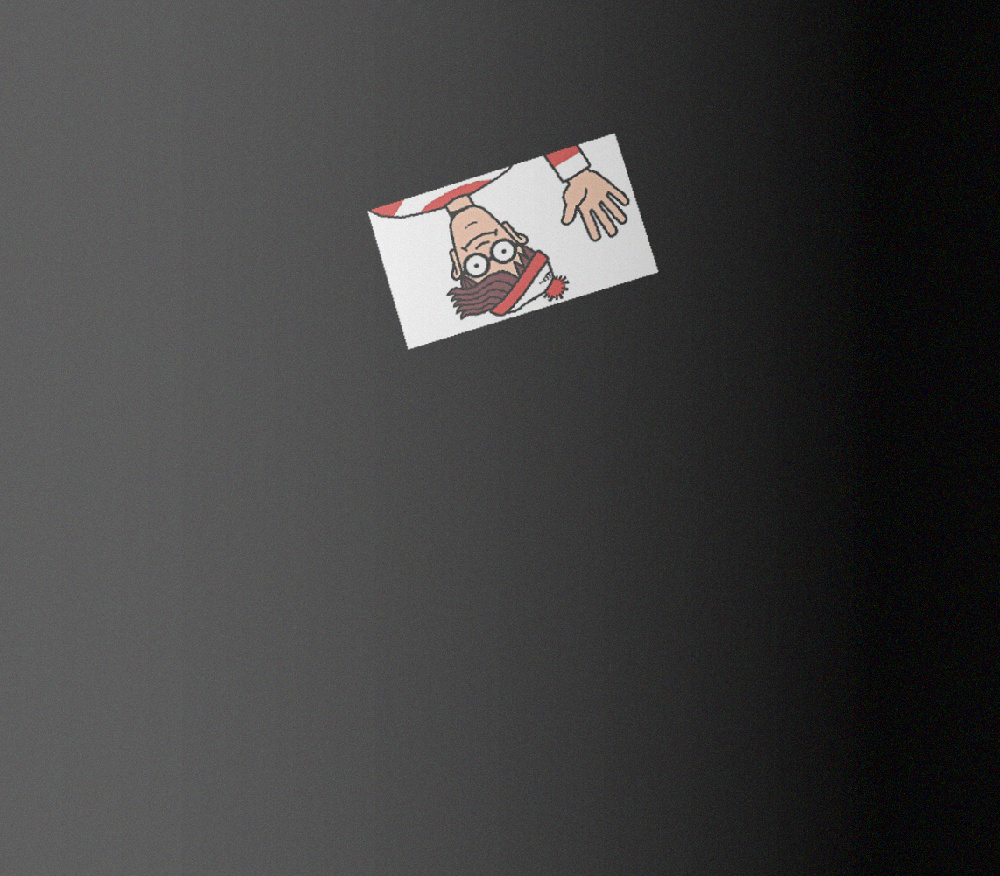

In [14]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

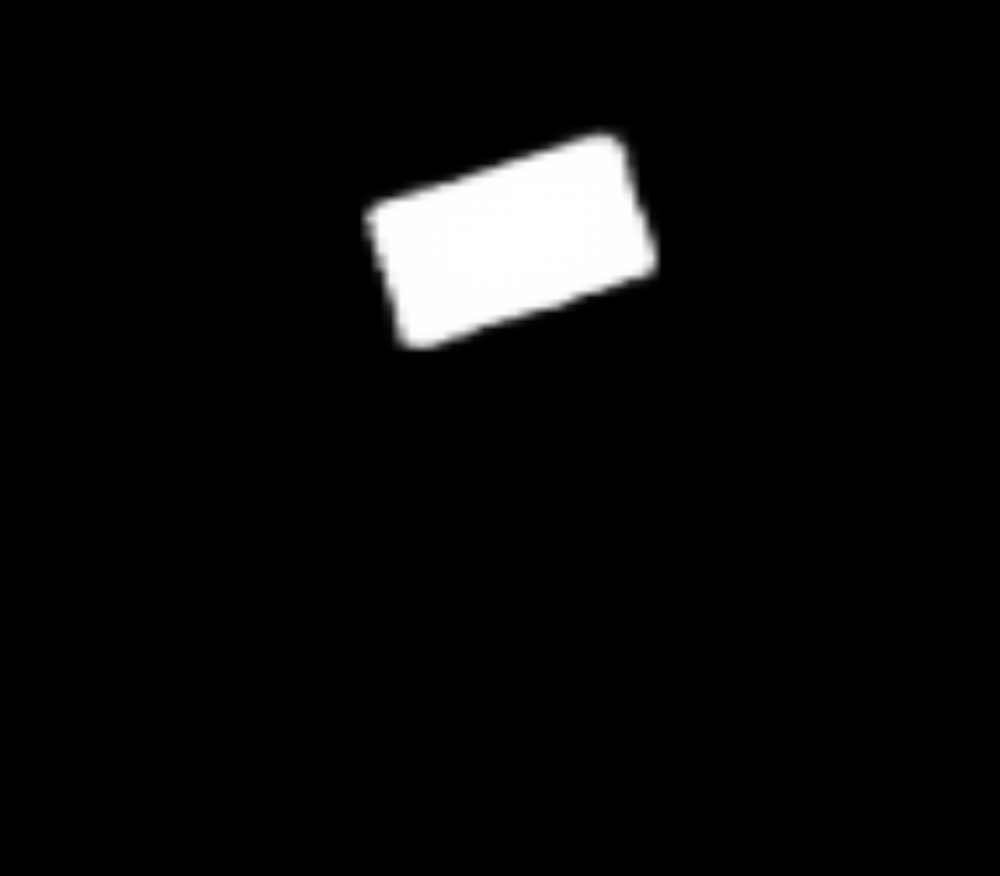

In [15]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

## Run the inference on the Test Set to create the result csv file.

In [16]:
import transforms

# put the model in evaluation mode
model.eval()

test_path = root_folder + '01-WheresWally/TestSet/'

test_image_paths = list(sorted(glob.glob(test_path + '*.jpg')))

transform_image = get_transform()

result_file_csv = './results_cnn_test.csv'
csv_file = open(result_file_csv, "w")

for test_image_path in test_image_paths:
  print(test_image_path)
  img = Image.open(test_image_path)
  img, _ = transform_image(img, _)
  with torch.no_grad():
    prediction = model([img.to(device)])
  
  prediction_box = prediction[0]['boxes'][0]
  prediction_box = prediction_box.cpu().detach().numpy()
  center_prediction = [prediction_box[0] + prediction_box[2] / 2, prediction_box[1] + prediction_box[3] / 2]
  csv_file.write(os.path.basename(test_image_path) + ',' + str(center_prediction[0]) + ',' + str(center_prediction[1]) + '\n')

print('Created file: ' + result_file_csv)
csv_file.close()

data/01-WheresWally/TestSet/wally_004.jpg
data/01-WheresWally/TestSet/wally_005.jpg
data/01-WheresWally/TestSet/wally_010.jpg
data/01-WheresWally/TestSet/wally_016.jpg
data/01-WheresWally/TestSet/wally_021.jpg
data/01-WheresWally/TestSet/wally_025.jpg
data/01-WheresWally/TestSet/wally_041.jpg
data/01-WheresWally/TestSet/wally_051.jpg
data/01-WheresWally/TestSet/wally_057.jpg
data/01-WheresWally/TestSet/wally_058.jpg
data/01-WheresWally/TestSet/wally_062.jpg
data/01-WheresWally/TestSet/wally_063.jpg
data/01-WheresWally/TestSet/wally_070.jpg
data/01-WheresWally/TestSet/wally_071.jpg
data/01-WheresWally/TestSet/wally_076.jpg
data/01-WheresWally/TestSet/wally_078.jpg
data/01-WheresWally/TestSet/wally_079.jpg
data/01-WheresWally/TestSet/wally_084.jpg
data/01-WheresWally/TestSet/wally_103.jpg
data/01-WheresWally/TestSet/wally_105.jpg
data/01-WheresWally/TestSet/wally_109.jpg
data/01-WheresWally/TestSet/wally_111.jpg
data/01-WheresWally/TestSet/wally_112.jpg
data/01-WheresWally/TestSet/wally_